✅ 2404 samples found in D:\golfDataset\dataset\train (balanced=True)
✅ 295 samples found in D:\golfDataset\dataset\test (balanced=False)

=== Fold 1/5 ===


  train acc: 49.558%, loss: 0.1778


  val  acc: 59.044%


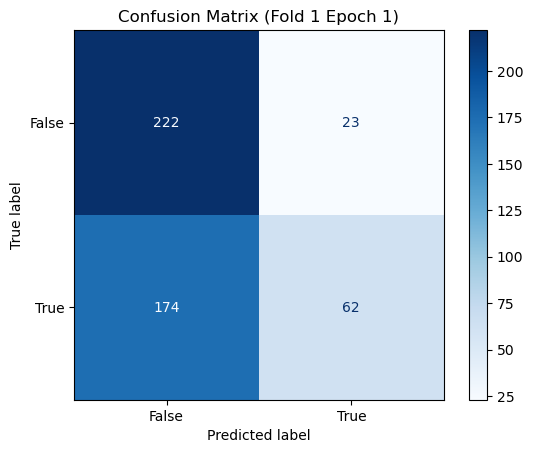

  train acc: 53.094%, loss: 0.1715


  val  acc: 61.746%


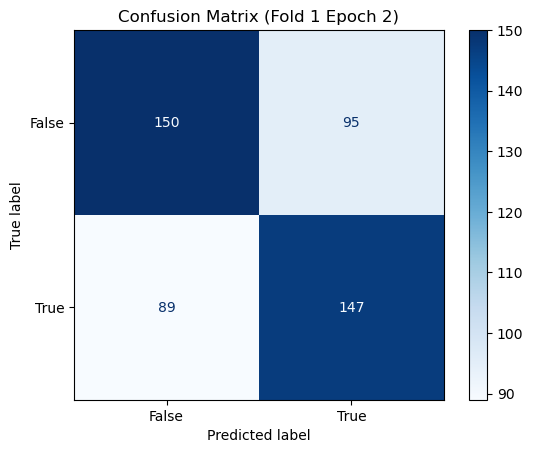

  train acc: 54.602%, loss: 0.1703


  val  acc: 50.936%


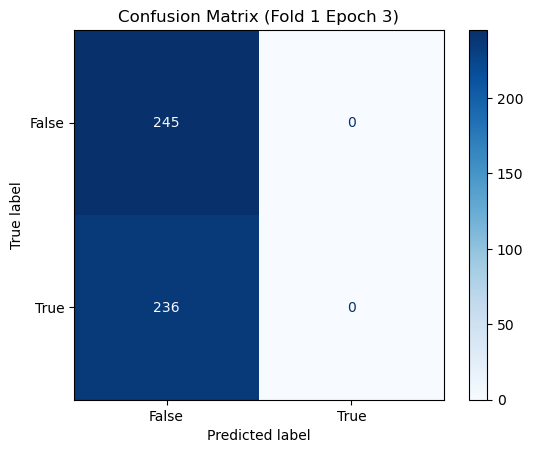

  train acc: 55.434%, loss: 0.1690


  val  acc: 57.796%


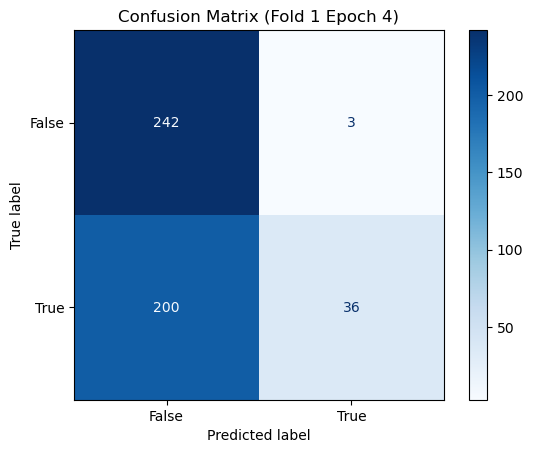

  train acc: 57.150%, loss: 0.1629


  val  acc: 69.231%


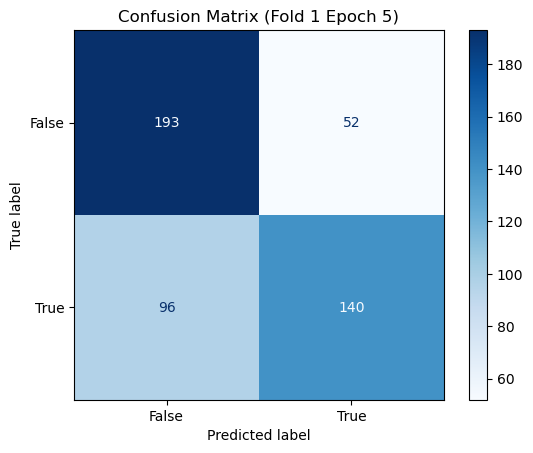

✔ Fold 1 test acc: 45.763%


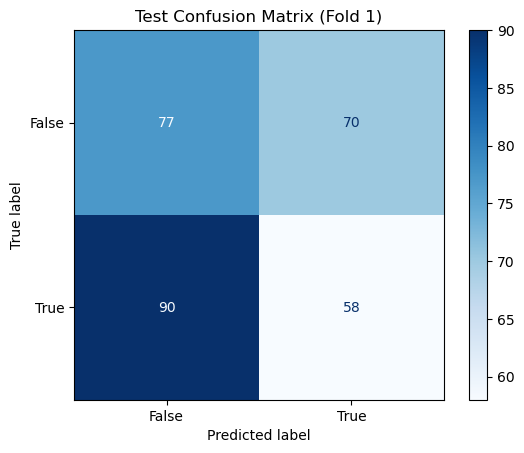


=== Fold 2/5 ===


  train acc: 51.534%, loss: 0.1801


  val  acc: 62.578%


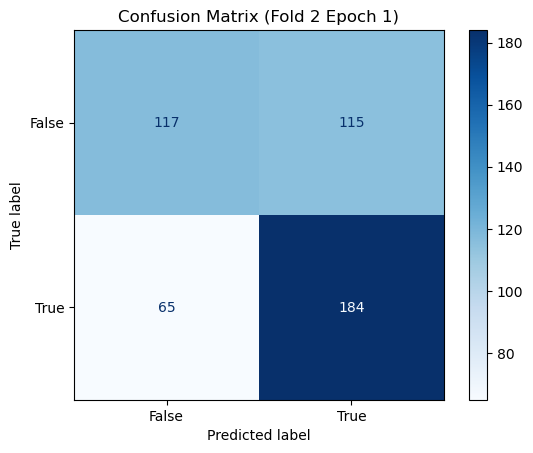

  train acc: 52.314%, loss: 0.1746


  val  acc: 48.233%


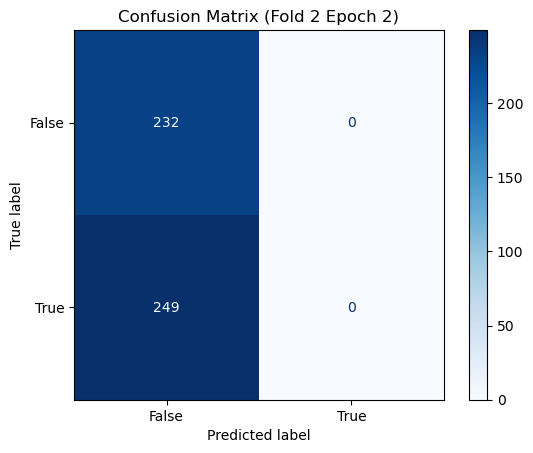

  train acc: 52.106%, loss: 0.1720


  val  acc: 58.004%


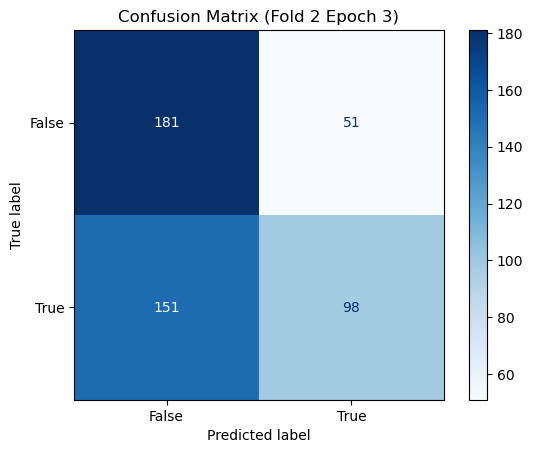

  train acc: 53.406%, loss: 0.1731


  val  acc: 48.233%


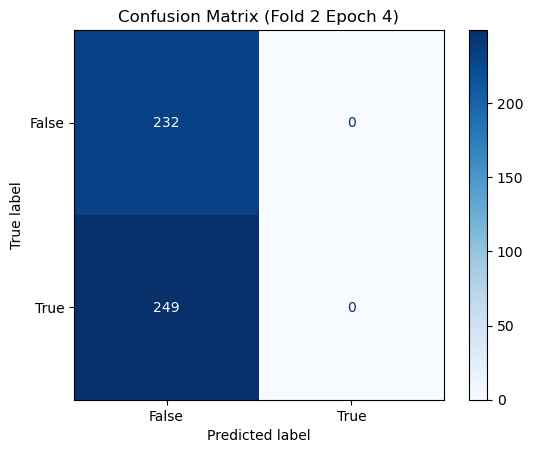

  train acc: 52.262%, loss: 0.1717


  val  acc: 48.233%


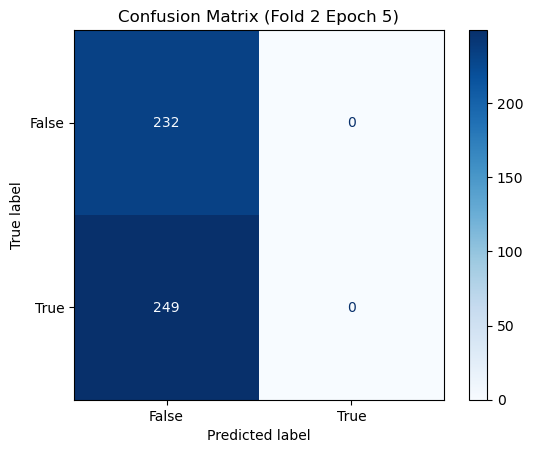

✔ Fold 2 test acc: 49.831%


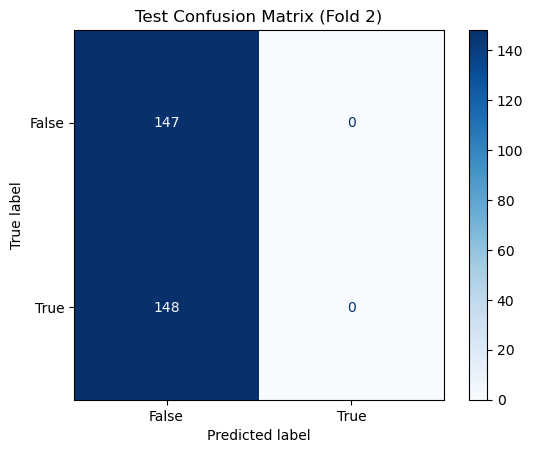


=== Fold 3/5 ===


  train acc: 52.730%, loss: 0.1819


  val  acc: 51.975%


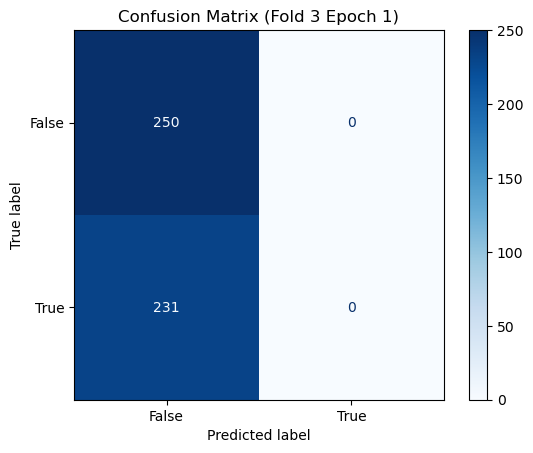

  train acc: 51.950%, loss: 0.1756


  val  acc: 51.975%


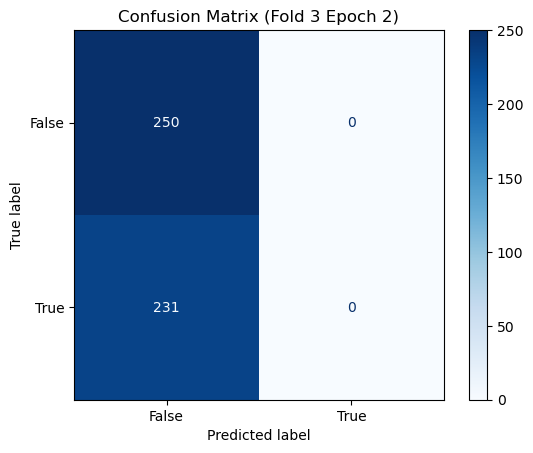

  train acc: 52.678%, loss: 0.1721


  val  acc: 54.886%


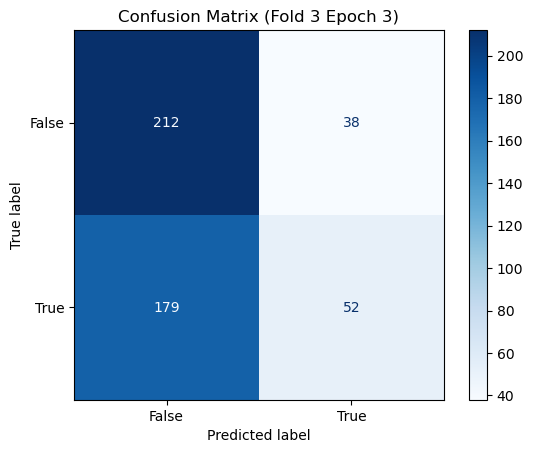

  train acc: 52.418%, loss: 0.1700


  val  acc: 55.717%


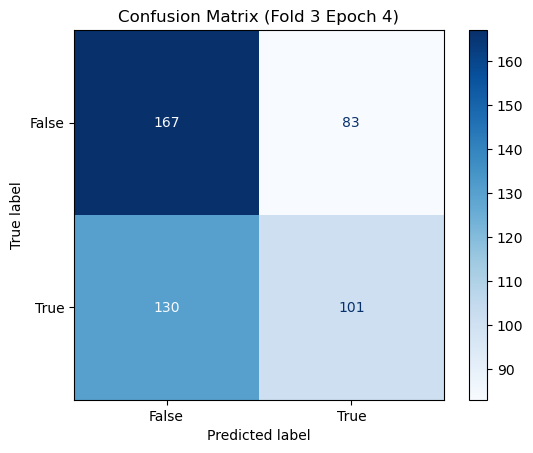

  train acc: 54.862%, loss: 0.1711


  val  acc: 57.796%


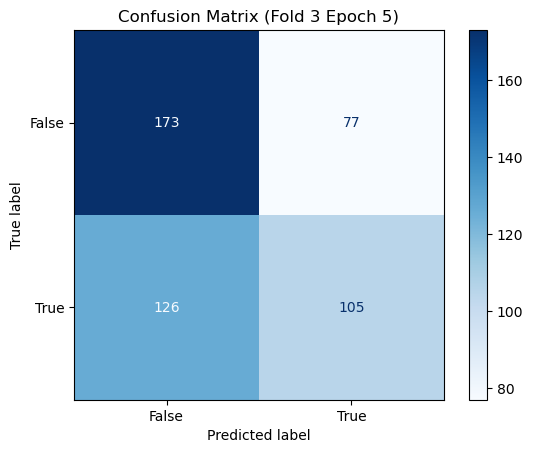

✔ Fold 3 test acc: 37.627%


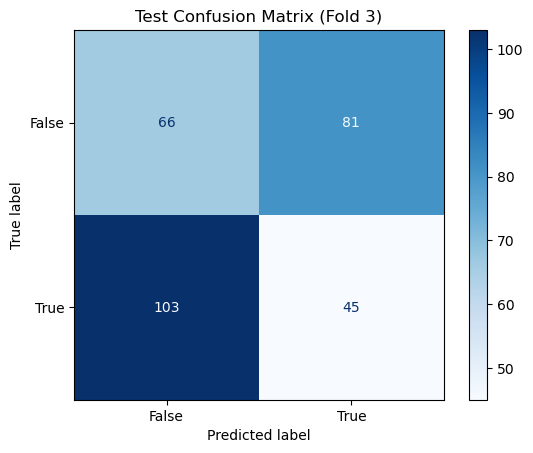


=== Fold 4/5 ===


  train acc: 50.338%, loss: 0.1931


  val  acc: 55.094%


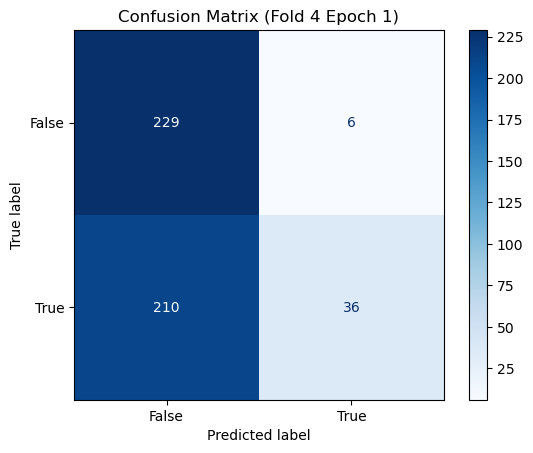

  train acc: 51.378%, loss: 0.1746


  val  acc: 48.857%


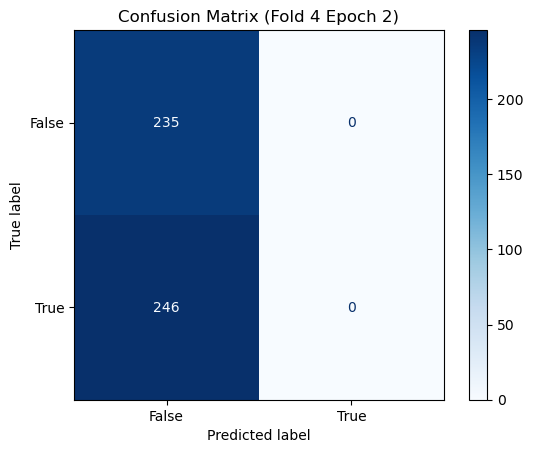

  train acc: 50.910%, loss: 0.1737


  val  acc: 51.143%


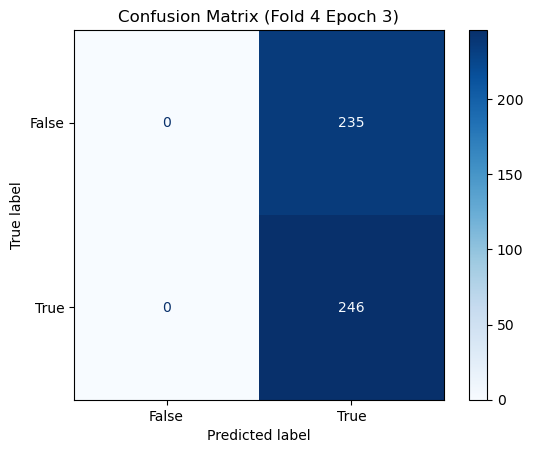

  train acc: 51.222%, loss: 0.1714


  val  acc: 48.857%


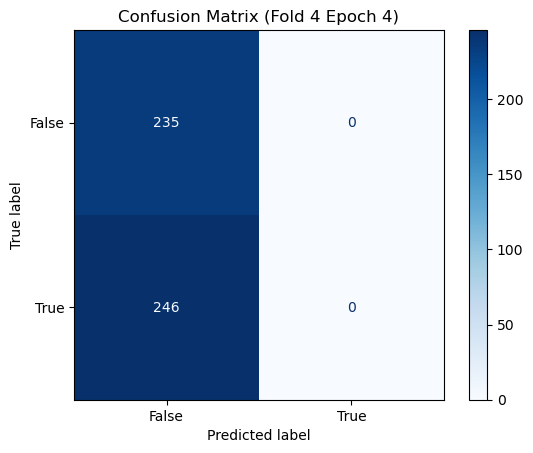

KeyboardInterrupt: 

In [ ]:
# Timesformer n-fold cross-validation (train/val 완전 분리)

import sys
sys.path.append(r"D:\\timesformer")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as T
from torchvision.transforms import functional as F, InterpolationMode
from pathlib import Path
import numpy as np
import random
from decord import VideoReader
from tqdm import tqdm
from timesformer.models.vit import TimeSformer
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.cuda.empty_cache()

# ----------------- 하이퍼파라미터 및 경로 ----------------------------
TRAIN_ROOT = Path(r"D:\golfDataset\dataset\train")
TEST_ROOT  = Path(r"D:\golfDataset\dataset\test")
PRETRAIN_PTH = Path(r"D:\timesformer\pretrained\TimeSformer_divST_8x32_224_K600.pyth")
NUM_FRAMES = 8
IMG_SIZE = 224
# ----------------- 조정 가능 파라미터 ----------------------------
CLIPS_PER_VIDEO = 1
BATCH_SIZE = 4
LR = 5e-5
WEIGHT_DECAY = 0.1
DROPOUT = 0.5
EPOCHS = 5
SEED = 42

N_FOLDS = 5
EPOCHS_DIR = Path("epochs")
EPOCHS_DIR.mkdir(exist_ok=True)

# ----------------- 재현성 ----------------------------
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------- 전처리 ----------------------------
def preprocess_tensor(img_tensor):
    img = F.resize(img_tensor, 256, interpolation=InterpolationMode.BICUBIC)
    img = F.center_crop(img, IMG_SIZE)
    img = F.normalize(img, [0.45]*3, [0.225]*3)
    return img

def uniform_sample(L, N):
    if L >= N:
        return np.linspace(0, L-1, N).astype(int)
    return np.pad(np.arange(L), (0, N-L), mode='edge')

def load_clip(path: Path):
    vr = VideoReader(str(path))
    L = len(vr)
    seg_edges = np.linspace(0, L, CLIPS_PER_VIDEO + 1, dtype=int)
    clips = []
    for s0, s1 in zip(seg_edges[:-1], seg_edges[1:]):
        idx = uniform_sample(s1 - s0, NUM_FRAMES) + s0
        arr = vr.get_batch(idx).asnumpy().astype(np.uint8)
        clip = torch.from_numpy(arr).permute(0, 3, 1, 2).float() / 255.0
        clip = torch.stack([preprocess_tensor(f) for f in clip])
        clips.append(clip.permute(1, 0, 2, 3))
    return clips

# ----------------- 모델 ----------------------------
class TimeSformerWithDropout(nn.Module):
    def __init__(self, base_model, dropout_p=DROPOUT):
        super().__init__()
        self.base = base_model
        self.dropout = nn.Dropout(dropout_p)
        self.head = base_model.model.head

    def forward(self, x):
        feats = self.base.model.forward_features(x)
        out = self.dropout(feats)
        return self.head(out)

# ----------------- 데이터셋 ----------------------------
class GolfSwingDataset(Dataset):
    def __init__(self, root: Path, balance):
        self.samples = []
        true_samples = []
        false_samples = []
        for label, sub in [(1, "balanced_true"), (0, "false")]:
            for p in (root/sub/"crop_video").glob("*.mp4"):
                if label == 1:
                    true_samples.append((p, 1))
                else:
                    false_samples.append((p, 0))
        if balance:
            n_true = len(true_samples)
            n_false = len(false_samples)
            if n_false > 0 and n_true > n_false:
                factor = n_true // n_false
                remainder = n_true % n_false
                false_samples = false_samples * factor + false_samples[:remainder]
        self.samples = true_samples + false_samples
        random.shuffle(self.samples)
        print(f"✅ {len(self.samples)} samples found in {root} (balanced={balance})")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        clips = load_clip(path)
        return torch.stack(clips), torch.tensor(label)

# ----------------- train/test 완전 분리 n-fold ----------------------------
train_dataset = GolfSwingDataset(TRAIN_ROOT, balance=True)
test_dataset  = GolfSwingDataset(TEST_ROOT, balance=False)

indices = np.arange(len(train_dataset))
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(indices)):
    print(f"\n=== Fold {fold+1}/{N_FOLDS} ===")
    train_subset = Subset(train_dataset, train_idx)
    val_subset   = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    val_loader   = DataLoader(val_subset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

    base_model = TimeSformer(img_size=IMG_SIZE, num_frames=NUM_FRAMES,
                             num_classes=2, attention_type='divided_space_time',
                             pretrained_model=str(PRETRAIN_PTH)).to(DEVICE)
    model = TimeSformerWithDropout(base_model, dropout_p=DROPOUT).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.5, 1.0]).to(DEVICE))

    best_val_acc = 0
    best_model_state = None
    for epoch in range(EPOCHS):
        # --- Training ---
        model.train()
        total = correct = total_loss = 0
        for clips, label in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1} [Train]", ncols=70, leave=False):
            B = clips.shape[0]
            clips = clips.view(-1, *clips.shape[2:]).to(DEVICE)
            labs = label.repeat(CLIPS_PER_VIDEO).to(DEVICE)
            outs = model(clips)
            loss = criterion(outs, labs)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            total_loss += loss.item()
            total += labs.size(0)
            correct += (outs.argmax(1) == labs).sum().item()
        train_acc = correct / total
        avg_loss = total_loss / total
        print(f"  train acc: {train_acc:.3%}, loss: {avg_loss:.4f}")

        # --- Validation ---
        model.eval()
        val_total = val_correct = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for clips, label in tqdm(val_loader, desc=f"Fold {fold+1} Epoch {epoch+1} [Val]", ncols=70, leave=False):
                B = clips.shape[0]
                vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)
                labs = label.repeat(CLIPS_PER_VIDEO).to(DEVICE)
                probs = model(vids).softmax(1)
                pred = probs.argmax(1)
                val_total += pred.size(0)
                val_correct += (pred.cpu() == labs.cpu()).sum().item()
                all_preds.extend(pred.cpu().numpy())
                all_labels.extend(labs.cpu().numpy())
        val_acc = val_correct / val_total if val_total > 0 else 0
        print(f"  val  acc: {val_acc:.3%}")

        # Confusion matrix 출력
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix (Fold {fold+1} Epoch {epoch+1})")
        plt.show()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()

    # --- Fold별 best 모델로 test set 평가 ---
    model.load_state_dict(best_model_state)
    model.eval()
    test_total = test_correct = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for clips, label in tqdm(test_loader, desc=f"Fold {fold+1} [Test]", ncols=70, leave=False):
            B = clips.shape[0]
            vids = clips.view(-1, *clips.shape[2:]).to(DEVICE)
            labs = label.repeat(CLIPS_PER_VIDEO).to(DEVICE)
            probs = model(vids).softmax(1)
            pred = probs.argmax(1)
            test_total += pred.size(0)
            test_correct += (pred.cpu() == labs.cpu()).sum().item()
            all_test_preds.extend(pred.cpu().numpy())
            all_test_labels.extend(labs.cpu().numpy())
    test_acc = test_correct / test_total if test_total > 0 else 0
    print(f"✔ Fold {fold+1} test acc: {test_acc:.3%}")

    # Confusion matrix (test)
    cm = confusion_matrix(all_test_labels, all_test_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])
    disp.plot(cmap="Blues")
    plt.title(f"Test Confusion Matrix (Fold {fold+1})")
    plt.show()

    fold_results.append(test_acc)

print(f"\n=== KFold 평균 test acc: {np.mean(fold_results):.3%} ===")